In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F

In [ ]:
!wget https://caltech256-bucket.s3.amazonaws.com/256_ObjectCategories.tar
!tar -xf 256_ObjectCategories.tar

--2023-06-16 02:02:57--  https://caltech256-bucket.s3.amazonaws.com/256_ObjectCategories.tar
Resolving caltech256-bucket.s3.amazonaws.com (caltech256-bucket.s3.amazonaws.com)... 52.217.91.116, 52.217.44.20, 52.216.236.219, ...
Connecting to caltech256-bucket.s3.amazonaws.com (caltech256-bucket.s3.amazonaws.com)|52.217.91.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1183006720 (1.1G) [application/x-tar]
Saving to: ‘256_ObjectCategories.tar’

256_ObjectCategorie 100%[===================>]   1.10G  57.7MB/s    in 18s     

2023-06-16 02:03:16 (62.1 MB/s) - ‘256_ObjectCategories.tar’ saved [1183006720/1183006720]



In [4]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 조기 종료로 32epoch 에서 최대 정확도가 나왔습니다.!

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define dataset_path and load the data
dataset_path = './256_ObjectCategories'
all_images = glob.glob(f'{dataset_path}/*/*.jpg')
all_labels = [os.path.basename(os.path.dirname(img)) for img in all_images]

# Train-test split (4:1 test_size=0.2)
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        labels = [int(label[:3])-1 for label in labels]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
img_size = 299  # ResNet200D requires input size of (224, 224)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    normalize
])

# Training data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    normalize
])

# Create custom datasets
train_dataset1 = CustomDataset(train_images, train_labels, transform=train_transform)
train_dataset2 = CustomDataset(train_images, train_labels, transform=transform)
train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
test_dataset = CustomDataset(test_images, test_labels, transform=transform)


# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create ResNet200D model
model = timm.create_model('resnet200d', pretrained=True)
num_classes = len(np.unique(all_labels))
model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),  # Add batch normalization
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# Lists to store accuracy values
train_acc_list = []
test_acc_list = []

# Train the model
epochs = 40
for epoch in range(epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == batch_y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_dataset)

    # Update learning rate
    scheduler.step()

    # Append train accuracy to the list
    train_acc_list.append(train_accuracy)

    # Evaluate the model
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_accuracy += (predicted == batch_y).sum().item()

        test_loss /= len(test_loader)
        test_accuracy /= len(test_dataset)

    # Append test accuracy to the list
    test_acc_list.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

# Plot the train and test accuracy
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/40
Train Loss: 2.2548 | Train Accuracy: 0.5773
Test Loss: 0.5438 | Test Accuracy: 0.8674
Epoch 2/40
Train Loss: 0.8128 | Train Accuracy: 0.8182
Test Loss: 0.4100 | Test Accuracy: 0.8995
Epoch 3/40
Train Loss: 0.6005 | Train Accuracy: 0.8649
Test Loss: 0.3819 | Test Accuracy: 0.9053
Epoch 4/40
Train Loss: 0.4663 | Train Accuracy: 0.8958
Test Loss: 0.3424 | Test Accuracy: 0.9188
Epoch 5/40
Train Loss: 0.4239 | Train Accuracy: 0.9058
Test Loss: 0.3336 | Test Accuracy: 0.9195
Epoch 6/40
Train Loss: 0.4009 | Train Accuracy: 0.9113
Test Loss: 0.3258 | Test Accuracy: 0.9209
Epoch 7/40
Train Loss: 0.3857 | Train Accuracy: 0.9154
Test Loss: 0.3312 | Test Accuracy: 0.9208
Epoch 8/40
Train Loss: 0.3832 | Train Accuracy: 0.9147
Test Loss: 0.3333 | Test Accuracy: 0.9198
Epoch 9/40
Train Loss: 0.3768 | Train Accuracy: 0.9155
Test Loss: 0.3253 | Test Accuracy: 0.9236
Epoch 10/40
Train Loss: 0.3751 | Train Accuracy: 0.9167
Test Loss: 0.3272 | Test Accuracy: 0.9213
Epoch 11/40
Train Loss: 0.380

KeyboardInterrupt: 

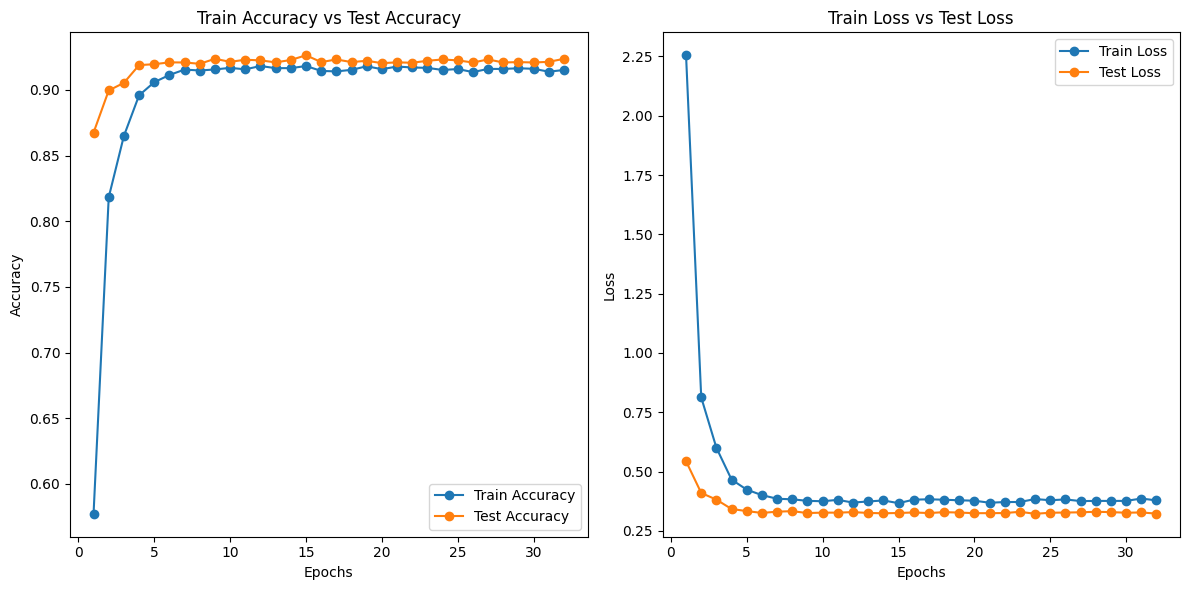

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 33)  # Epoch 범위

train_accuracy = [0.5773, 0.8182, 0.8649, 0.8958, 0.9058, 0.9113, 0.9154, 0.9147, 0.9155, 0.9167,
                  0.9156, 0.9181, 0.9165, 0.9165, 0.9181, 0.9144, 0.9140, 0.9152, 0.9179, 0.9157,
                  0.9177, 0.9170, 0.9167, 0.9151, 0.9158, 0.9135, 0.9159, 0.9159, 0.9164, 0.9160,
                  0.9138, 0.9151]
test_accuracy = [0.8674, 0.8995, 0.9053, 0.9188, 0.9195, 0.9209, 0.9208, 0.9198, 0.9236, 0.9213,
                 0.9229, 0.9224, 0.9209, 0.9227, 0.9263, 0.9211, 0.9231, 0.9211, 0.9221, 0.9203,
                 0.9209, 0.9206, 0.9221, 0.9231, 0.9224, 0.9208, 0.9231, 0.9208, 0.9211, 0.9208,
                 0.9213, 0.9236]
train_loss = [2.2548, 0.8128, 0.6005, 0.4663, 0.4239, 0.4009, 0.3857, 0.3832, 0.3768, 0.3751,
              0.3809, 0.3695, 0.3742, 0.3784, 0.3671, 0.3817, 0.3834, 0.3815, 0.3791, 0.3774,
              0.3688, 0.3717, 0.3720, 0.3843, 0.3794, 0.3827, 0.3758, 0.3765, 0.3765, 0.3766,
              0.3865, 0.3787]
test_loss = [0.5438, 0.4100, 0.3819, 0.3424, 0.3336, 0.3258, 0.3312, 0.3333, 0.3253, 0.3272,
             0.3270, 0.3293, 0.3258, 0.3244, 0.3256, 0.3278, 0.3253, 0.3291, 0.3274, 0.3248,
             0.3249, 0.3254, 0.3306, 0.3222, 0.3267, 0.3275, 0.3285, 0.3307, 0.3293, 0.3267,
             0.3279, 0.3230]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, marker='o', label='Train Accuracy')
plt.plot(epochs, test_accuracy, marker='o', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Test Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, test_loss, marker='o', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()

plt.tight_layout()
plt.show()
